In [ ]:
!pip install imbalanced-learn shap


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Load NSL-KDD dataset (including the 'difficulty' score column)
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

# Load the data
train_path = '/content/KDDTrain+.txt'
test_path = '/content/KDDTest+.txt'
df_train = pd.read_csv(train_path, names=columns)
df_test = pd.read_csv(test_path, names=columns)

# Drop the 'difficulty' column
df_train.drop('difficulty', axis=1, inplace=True)
df_test.drop('difficulty', axis=1, inplace=True)

# Convert all attacks to a single 'attack' label (binary classification)
df_train['label'] = df_train['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')
df_test['label'] = df_test['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')

# One-hot encode categorical features (protocol_type, service, flag)
df_train_encoded = pd.get_dummies(df_train, columns=["protocol_type", "service", "flag"])
df_test_encoded = pd.get_dummies(df_test, columns=["protocol_type", "service", "flag"])

# Align columns between train and test sets
df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='left', axis=1, fill_value=0)

# Extract labels
le = LabelEncoder()
y_train = le.fit_transform(df_train_encoded['label'])  # 0: attack, 1: normal
y_test = le.transform(df_test_encoded['label'])

# Drop label columns
X_train = df_train_encoded.drop(['label'], axis=1)
X_test = df_test_encoded.drop(['label'], axis=1)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Confirm class balance
print("Class distribution before SMOTE:\n", pd.Series(y_train).value_counts())
print("Class distribution after SMOTE:\n", pd.Series(y_train_resampled).value_counts())


Class distribution before SMOTE:
 1    67343
0    58630
Name: count, dtype: int64
Class distribution after SMOTE:
 1    67343
0    67343
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define base classifiers
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf3 = LogisticRegression(max_iter=1000)

# Voting for ensemble
ensemble_model = VotingClassifier(
    estimators=[('rf', clf1), ('gb', clf2), ('lr', clf3)],
    voting='soft'
)

ensemble_model.fit(X_train_resampled, y_train_resampled)
y_pred = ensemble_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7753726046841731
              precision    recall  f1-score   support

      attack       0.97      0.63      0.76     12833
      normal       0.66      0.97      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.77     22544
weighted avg       0.84      0.78      0.77     22544



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical


In [ ]:

# Restore multi-class labels from the raw dataset
df_train_mc = pd.read_csv(train_path, names=columns)
df_test_mc = pd.read_csv(test_path, names=columns)

# Drop difficulty
df_train_mc.drop('difficulty', axis=1, inplace=True)
df_test_mc.drop('difficulty', axis=1, inplace=True)

# Remove unseen test labels (i.e., attack types not in train)
known_labels = set(df_train_mc['label'].unique())
df_test_mc = df_test_mc[df_test_mc['label'].isin(known_labels)]

# One-hot encode categorical
df_train_mc = pd.get_dummies(df_train_mc, columns=["protocol_type", "service", "flag"])
df_test_mc = pd.get_dummies(df_test_mc, columns=["protocol_type", "service", "flag"])

# Align columns
df_train_mc, df_test_mc = df_train_mc.align(df_test_mc, join='left', axis=1, fill_value=0)

# Encode target
le_mc = LabelEncoder()
y_train_mc = le_mc.fit_transform(df_train_mc['label'])
y_test_mc = le_mc.transform(df_test_mc['label'])

X_train_mc = df_train_mc.drop(['label'], axis=1)
X_test_mc = df_test_mc.drop(['label'], axis=1)


UPDATED SMOTE (To avoid less sample wala issue)

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Get class distribution
class_counts = Counter(y_train_mc)
min_class_count = min(class_counts.values())

# Adjust k_neighbors to avoid crashing
k_neighbors = min(min_class_count - 1, 5)
print(f"Using SMOTE with k_neighbors={k_neighbors} (min class count = {min_class_count})")

# Apply SMOTE safely
sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_mc_resampled, y_train_mc_resampled = sm.fit_resample(X_train_mc, y_train_mc)


Using SMOTE with k_neighbors=1 (min class count = 2)


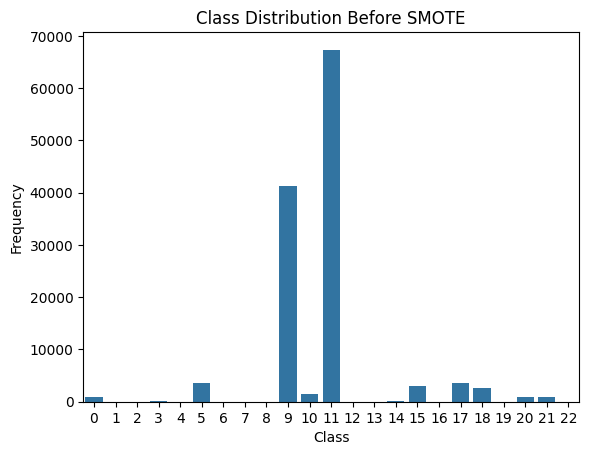

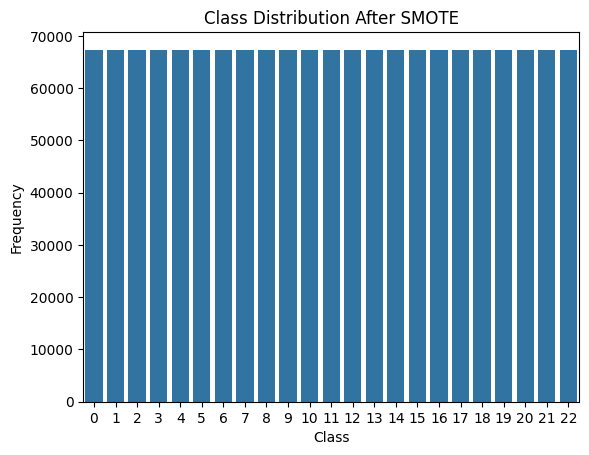

In [ ]:
import pandas as pd
import seaborn as sns

def plot_class_distribution(y, title='Class Distribution'):
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()


# Before SMOTE
plot_class_distribution(y_train_mc, title='Class Distribution Before SMOTE')

# After SMOTE
plot_class_distribution(y_train_mc_resampled, title='Class Distribution After SMOTE')


In [ ]:
# Reload full dataset with multi-class labels
df_train_mc = pd.read_csv(train_path, names=columns)
df_test_mc = pd.read_csv(test_path, names=columns)

# Drop 'difficulty'
df_train_mc.drop('difficulty', axis=1, inplace=True)
df_test_mc.drop('difficulty', axis=1, inplace=True)

# Remove unseen test labels (i.e., attack types not in train)
known_labels = set(df_train_mc['label'].unique())
df_test_mc = df_test_mc[df_test_mc['label'].isin(known_labels)]

# One-hot encode categorical
df_train_mc = pd.get_dummies(df_train_mc, columns=["protocol_type", "service", "flag"])
df_test_mc = pd.get_dummies(df_test_mc, columns=["protocol_type", "service", "flag"])

# Align columns
df_train_mc, df_test_mc = df_train_mc.align(df_test_mc, join='left', axis=1, fill_value=0)

# Encode target labels
from sklearn.preprocessing import LabelEncoder
le_mc = LabelEncoder()
y_train_mc = le_mc.fit_transform(df_train_mc['label'])
y_test_mc = le_mc.transform(df_test_mc['label'])

X_train_mc = df_train_mc.drop(['label'], axis=1)
X_test_mc = df_test_mc.drop(['label'], axis=1)

# Apply SMOTE on multi-class
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_train_mc_resampled, y_train_mc_resampled = sm.fit_resample(X_train_mc, y_train_mc)

# One-hot encode for deep learning
from tensorflow.keras.utils import to_categorical
y_train_mc_cat = to_categorical(y_train_mc_resampled)
y_test_mc_cat = to_categorical(y_test_mc)


In [ ]:
input_dim = X_train_resampled.shape[1]
hidden_units = 50
epochs = 20
batch_size = 128

def build_mlp(input_dim, output_dim):
    inp = Input(shape=(input_dim,))
    x = Dense(hidden_units, activation='relu')(inp)
    out = Dense(output_dim, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_dim, output_dim):
    inp = Input(shape=(1, input_dim))
    x = LSTM(hidden_units)(inp)
    out = Dense(output_dim, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_autoencoder_classifier(input_dim, output_dim):
    inp = Input(shape=(input_dim,))
    encoded = Dense(hidden_units, activation='relu')(inp)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=inp, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(X_train_resampled, X_train_resampled, epochs=10, batch_size=batch_size, verbose=0)

    # Use encoder output for classification
    encoder = Model(inputs=inp, outputs=encoded)
    encoded_input = encoder.predict(X_train_resampled)
    classifier_inp = Input(shape=(hidden_units,))
    x = Dense(output_dim, activation='softmax')(classifier_inp)
    classifier = Model(inputs=classifier_inp, outputs=x)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier, encoder


In [ ]:
# Binary Classification (AE, MLP, LSTM, LDA)
results = {}

# MLP
mlp_bin = build_mlp(input_dim, 2)
mlp_bin.fit(X_train_resampled, to_categorical(y_train_resampled), epochs=epochs, batch_size=batch_size, verbose=0)
mlp_preds = np.argmax(mlp_bin.predict(X_test), axis=1)
results['MLP'] = f1_score(y_test, mlp_preds, average='weighted')

# AE
ae_bin, ae_encoder = build_autoencoder_classifier(input_dim, 2)
ae_encoded_train = ae_encoder.predict(X_train_resampled)
ae_encoded_test = ae_encoder.predict(X_test)
ae_bin.fit(ae_encoded_train, to_categorical(y_train_resampled), epochs=epochs, batch_size=batch_size, verbose=0)
ae_preds = np.argmax(ae_bin.predict(ae_encoded_test), axis=1)
results['AE'] = f1_score(y_test, ae_preds, average='weighted')

# LSTM
# X_train_lstm = X_train_resampled.values.reshape(-1, 1, input_dim)
# After:
# X_train_lstm = X_train_resampled.astype(np.float32).values.reshape(-1, 1, input_dim)

# X_test_lstm = X_test.values.reshape(-1, 1, input_dim)
# lstm_bin = build_lstm(input_dim, 2)
# lstm_bin.fit(X_train_lstm, to_categorical(y_train_resampled), epochs=epochs, batch_size=batch_size, verbose=0)
# lstm_preds = np.argmax(lstm_bin.predict(X_test_lstm), axis=1)
# results['LSTM'] = f1_score(y_test, lstm_preds, average='weighted')

X_train_lstm = X_train_resampled.astype(np.float32).values.reshape(-1, 1, input_dim)
X_test_lstm = X_test.astype(np.float32).values.reshape(-1, 1, input_dim) # Convert to float32

lstm_bin = build_lstm(input_dim, 2)
lstm_bin.fit(X_train_lstm, to_categorical(y_train_resampled), epochs=epochs, batch_size=batch_size, verbose=0)
lstm_preds = np.argmax(lstm_bin.predict(X_test_lstm), axis=1)
results['LSTM'] = f1_score(y_test, lstm_preds, average='weighted')

# LDA
lda_bin = LinearDiscriminantAnalysis()
lda_bin.fit(X_train_resampled, y_train_resampled)
lda_preds = lda_bin.predict(X_test)
results['LDA'] = f1_score(y_test, lda_preds, average='weighted')

print("Binary Classification F1 Scores:")
for model, score in results.items():
    print(f"{model}: {score:.4f}")


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Binary Classification F1 Scores:
MLP: 0.7415
AE: 0.5590
LSTM: 0.7696
LDA: 0.7619


In [ ]:
# Reload and preprocess data
df_train_mc = pd.read_csv(train_path, names=columns)
df_test_mc = pd.read_csv(test_path, names=columns)

# Drop 'difficulty'
df_train_mc.drop('difficulty', axis=1, inplace=True)
df_test_mc.drop('difficulty', axis=1, inplace=True)

# Remove unseen labels in test set
known_labels = set(df_train_mc['label'].unique())
df_test_mc = df_test_mc[df_test_mc['label'].isin(known_labels)]

# One-hot encode categorical
df_train_mc = pd.get_dummies(df_train_mc, columns=["protocol_type", "service", "flag"])
df_test_mc = pd.get_dummies(df_test_mc, columns=["protocol_type", "service", "flag"])

# Align columns
df_train_mc, df_test_mc = df_train_mc.align(df_test_mc, join='left', axis=1, fill_value=0)

# Encode labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le_mc = LabelEncoder()
y_train_mc = le_mc.fit_transform(df_train_mc['label'])
y_test_mc = le_mc.transform(df_test_mc['label'])

X_train_mc = df_train_mc.drop(['label'], axis=1)
X_test_mc = df_test_mc.drop(['label'], axis=1)

# One-hot encode labels for DL
y_train_mc_cat = to_categorical(y_train_mc)
y_test_mc_cat = to_categorical(y_test_mc)


In [ ]:
# MLP
mlp_mc = build_mlp(X_train_mc.shape[1], y_train_mc_cat.shape[1])
mlp_mc.fit(X_train_mc, y_train_mc_cat, epochs=epochs, batch_size=batch_size, verbose=0)
mlp_mc_preds = np.argmax(mlp_mc.predict(X_test_mc), axis=1)

# AE
ae_mc, ae_enc = build_autoencoder_classifier(X_train_mc.shape[1], y_train_mc_cat.shape[1])
ae_enc_train = ae_enc.predict(X_train_mc)
ae_enc_test = ae_enc.predict(X_test_mc)
ae_mc.fit(ae_enc_train, y_train_mc_cat, epochs=epochs, batch_size=batch_size, verbose=0)
ae_mc_preds = np.argmax(ae_mc.predict(ae_enc_test), axis=1)

# LSTM
X_train_mc_lstm = X_train_mc.astype(np.float32).values.reshape(-1, 1, X_train_mc.shape[1])
X_test_mc_lstm = X_test_mc.astype(np.float32).values.reshape(-1, 1, X_test_mc.shape[1])

lstm_mc = build_lstm(X_train_mc.shape[1], y_train_mc_cat.shape[1])
lstm_mc.fit(X_train_mc_lstm, y_train_mc_cat, epochs=epochs, batch_size=batch_size, verbose=0)
lstm_mc_preds = np.argmax(lstm_mc.predict(X_test_mc_lstm), axis=1)


588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
from sklearn.metrics import f1_score, classification_report

models_mc = {
    "MLP": mlp_mc_preds,
    "AE": ae_mc_preds,
    "LSTM": lstm_mc_preds
}

print("\nMulti-Class F1 Score:")
for name, preds in models_mc.items():
    score = f1_score(y_test_mc, preds, average='weighted')
    print(f"{name}: {score:.4f}")

# Optional: Detailed report
for name, preds in models_mc.items():
    print(f"\n📋 Classification Report for {name}:")
    # Get unique labels present in y_test_mc and preds
    unique_labels_test = np.unique(np.concatenate((y_test_mc, preds)))

    # Filter target_names to include only labels present in test set and predictions
    target_names_test = [le_mc.classes_[i] for i in unique_labels_test]

    print(classification_report(y_test_mc, preds, target_names=target_names_test, zero_division=0))


Multi-Class F1 Score:
MLP: 0.8079
AE: 0.6985
LSTM: 0.7853

📋 Classification Report for MLP:
                 precision    recall  f1-score   support

           back       0.82      0.99      0.90       359
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.00      0.00      0.00      1231
           imap       0.00      0.00      0.00         1
        ipsweep       0.74      0.97      0.84       141
           land       1.00      0.43      0.60         7
     loadmodule       0.00      0.00      0.00         2
       multihop       0.00      0.00      0.00        18
        neptune       1.00      0.99      1.00      4657
           nmap       0.80      0.99      0.88        73
         normal       0.82      0.96      0.88      9711
           perl       0.00      0.00      0.00         2
            phf       0.00      0.00      0.00         2
            pod       0.40      0.15      0.21     

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Define metric function
def get_metrics(y_true, y_pred, average='weighted'):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "Recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, average=average, zero_division=0)
    }

# Compute metrics for each model
results_table = {}
for name, preds in models_mc.items():
    results_table[name] = get_metrics(y_test_mc, preds)

# Display as formatted table
df_results = pd.DataFrame(results_table).T.round(4)
print("📊 Multi-Class Classification Metrics:\n")
display(df_results)


📊 Multi-Class Classification Metrics:



,Accuracy,Precision,Recall,F1-Score
MLP,0.8548,0.7690,0.8548,0.8079
AE,0.6890,0.7169,0.6890,0.6985
LSTM,0.8437,0.8166,0.8437,0.7853


<ipython-input-19-b6e115580bb1>:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


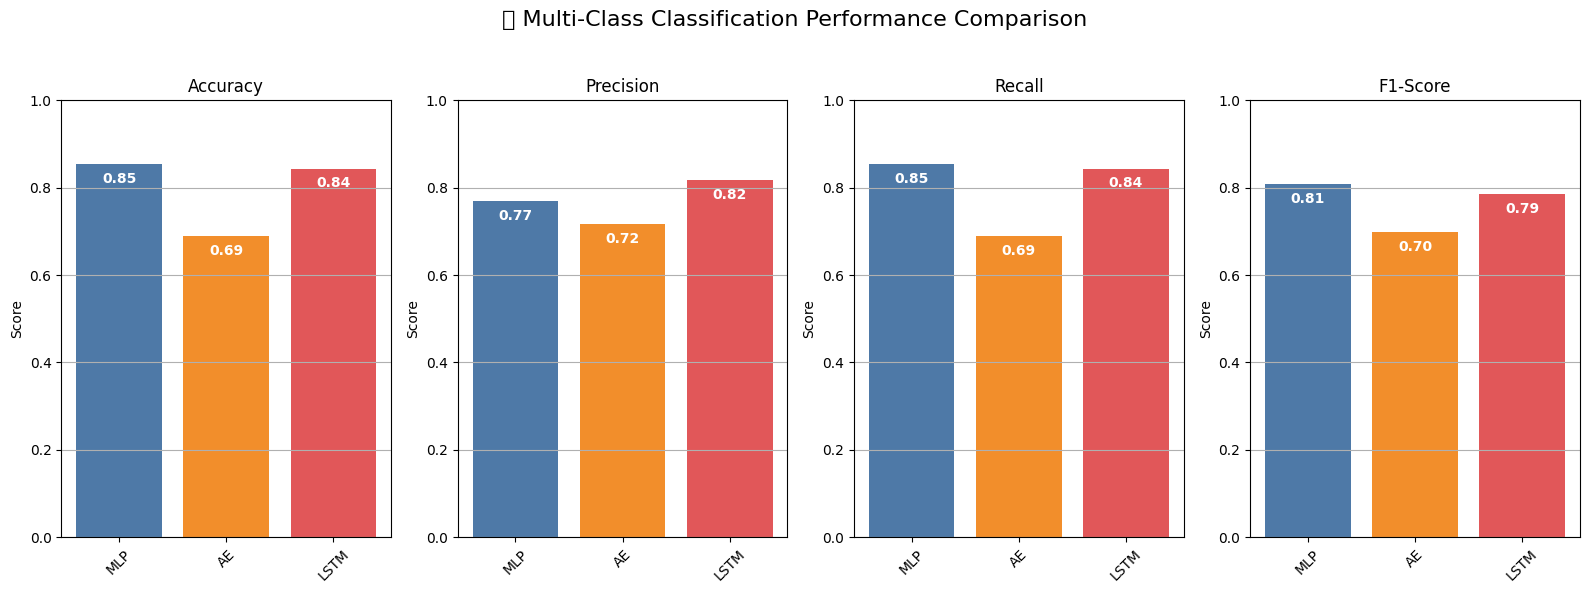

In [ ]:
import matplotlib.pyplot as p# Plot settings
metrics = df_results.columns
models = df_results.index
colors = ['#4e79a7', '#f28e2b', '#e15759']  # Colors for bars

# Plot each metric
plt.figure(figsize=(16, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i + 1)
    bars = plt.bar(models, df_results[metric], color=colors)
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.ylabel("Score")
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height - 0.05, f"{height:.2f}", ha='center', va='bottom', color='white', fontweight='bold')
    plt.grid(axis='y')

plt.suptitle("🔍 Multi-Class Classification Performance Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


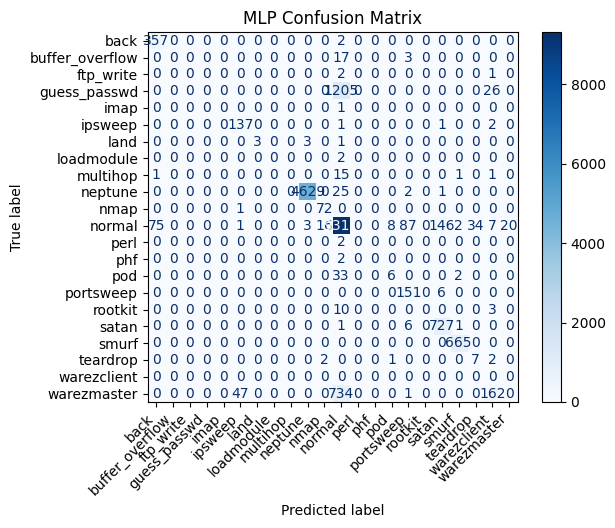

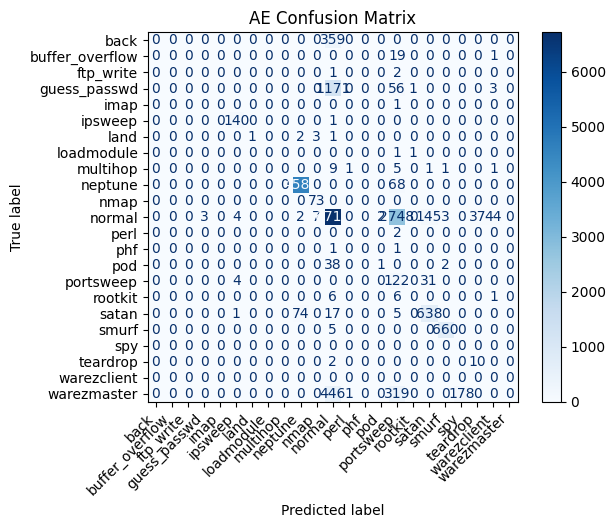

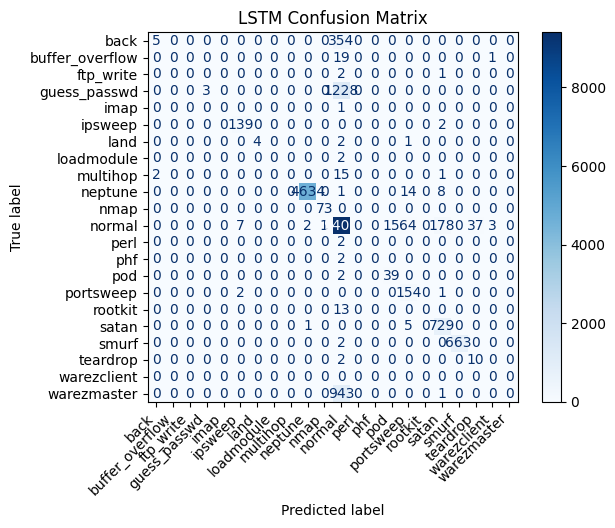

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_conf_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    # Get unique labels present in y_true and y_pred
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))

    # Filter labels to include only those present in test set and predictions
    labels = [labels[i] for i in unique_labels]

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels) # Specify labels here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.show()


# USAGE
plot_conf_matrix(y_test_mc, mlp_mc_preds, labels=le_mc.classes_, title="MLP Confusion Matrix")
plot_conf_matrix(y_test_mc, ae_mc_preds, labels=le_mc.classes_, title="AE Confusion Matrix")
plot_conf_matrix(y_test_mc, lstm_mc_preds, labels=le_mc.classes_, title="LSTM Confusion Matrix")

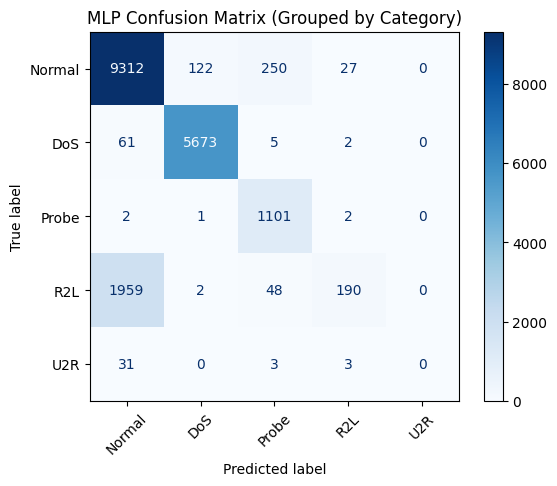

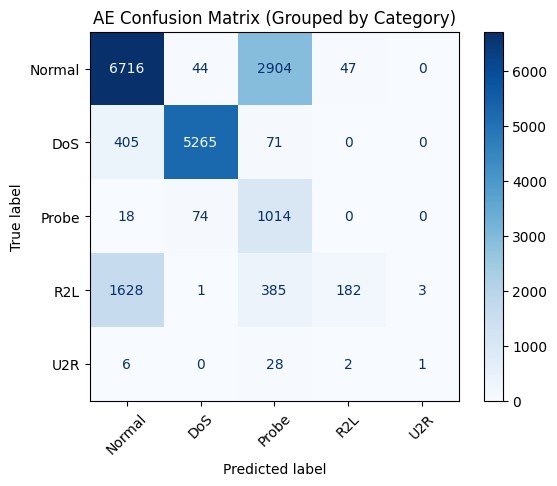

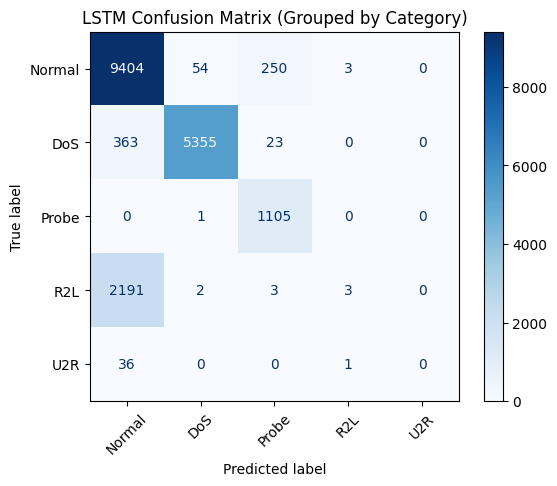

In [ ]:
# === Group Mapping ===
category_map = {
    'normal': 'Normal',
    'neptune': 'DoS', 'smurf': 'DoS', 'back': 'DoS', 'teardrop': 'DoS', 'pod': 'DoS', 'land': 'DoS',
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'warezclient': 'R2L', 'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'imap': 'R2L', 'warezmaster': 'R2L',
    'rootkit': 'U2R', 'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R',  'spy': 'R2L'
}

group_labels = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']

# === Convert y_test_mc (true labels) to grouped labels ===
y_true_cat = [category_map[label] for label in le_mc.inverse_transform(y_test_mc)]

# === Convert predictions to grouped categories ===
y_pred_cat_mlp = [category_map[label] for label in le_mc.inverse_transform(mlp_mc_preds)]
y_pred_cat_ae = [category_map[label] for label in le_mc.inverse_transform(ae_mc_preds)]
y_pred_cat_lstm = [category_map[label] for label in le_mc.inverse_transform(lstm_mc_preds)]

# === Function to plot grouped confusion matrix ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_grouped_conf_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# === Plot for all models ===
plot_grouped_conf_matrix(y_true_cat, y_pred_cat_mlp, group_labels, title="MLP Confusion Matrix (Grouped by Category)")
plot_grouped_conf_matrix(y_true_cat, y_pred_cat_ae, group_labels, title="AE Confusion Matrix (Grouped by Category)")
plot_grouped_conf_matrix(y_true_cat, y_pred_cat_lstm, group_labels, title="LSTM Confusion Matrix (Grouped by Category)")


In [ ]:
# Check unique labels in y_test_mc (true labels)
unique_labels_true = set(le_mc.inverse_transform(y_test_mc))
print("Unique labels in y_test_mc:", unique_labels_true)

# Check unique labels in model predictions
unique_labels_mlp = set(le_mc.inverse_transform(mlp_mc_preds))
unique_labels_ae = set(le_mc.inverse_transform(ae_mc_preds))
unique_labels_lstm = set(le_mc.inverse_transform(lstm_mc_preds))

print("Unique labels in MLP predictions:", unique_labels_mlp)
print("Unique labels in AE predictions:", unique_labels_ae)
print("Unique labels in LSTM predictions:", unique_labels_lstm)

# Check for missing labels in category_map
missing_labels = (unique_labels_true | unique_labels_mlp | unique_labels_ae | unique_labels_lstm) - set(category_map.keys())

if missing_labels:
    print("\nWarning: The following labels are not present in category_map:", missing_labels)
else:
    print("\nAll labels are present in category_map.")

Unique labels in y_test_mc: {'loadmodule', 'phf', 'smurf', 'pod', 'teardrop', 'warezmaster', 'imap', 'ipsweep', 'neptune', 'nmap', 'normal', 'guess_passwd', 'buffer_overflow', 'ftp_write', 'rootkit', 'satan', 'portsweep', 'land', 'multihop', 'perl', 'back'}
Unique labels in MLP predictions: {'satan', 'portsweep', 'smurf', 'land', 'normal', 'warezclient', 'pod', 'ipsweep', 'back', 'neptune', 'teardrop', 'nmap', 'warezmaster'}
Unique labels in AE predictions: {'satan', 'portsweep', 'smurf', 'land', 'normal', 'spy', 'warezclient', 'pod', 'guess_passwd', 'perl', 'ipsweep', 'neptune', 'teardrop', 'nmap', 'rootkit'}
Unique labels in LSTM predictions: {'satan', 'smurf', 'portsweep', 'land', 'normal', 'guess_passwd', 'pod', 'warezclient', 'ipsweep', 'back', 'neptune', 'teardrop', 'nmap'}

All labels are present in category_map.


In [ ]:
# Get all labels from category_map
category_map_labels = set(category_map.keys())

# Get all unique labels from true labels and predictions
all_data_labels = unique_labels_true | unique_labels_mlp | unique_labels_ae | unique_labels_lstm

# Find labels in category_map but not in data
unused_labels = category_map_labels - all_data_labels

if unused_labels:
    print("\nWarning: The following labels are in category_map but not present in the data or predictions:", unused_labels)
else:
    print("\nAll labels in category_map are used in the data or predictions.")


All labels in category_map are used in the data or predictions.


588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


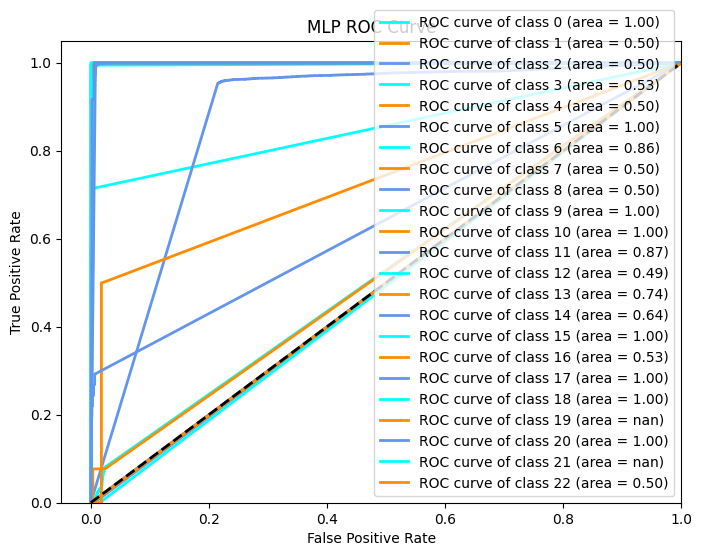

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


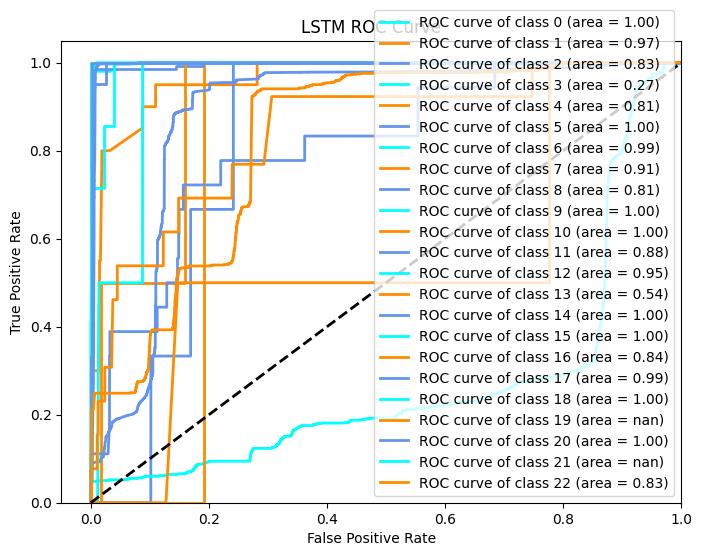

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


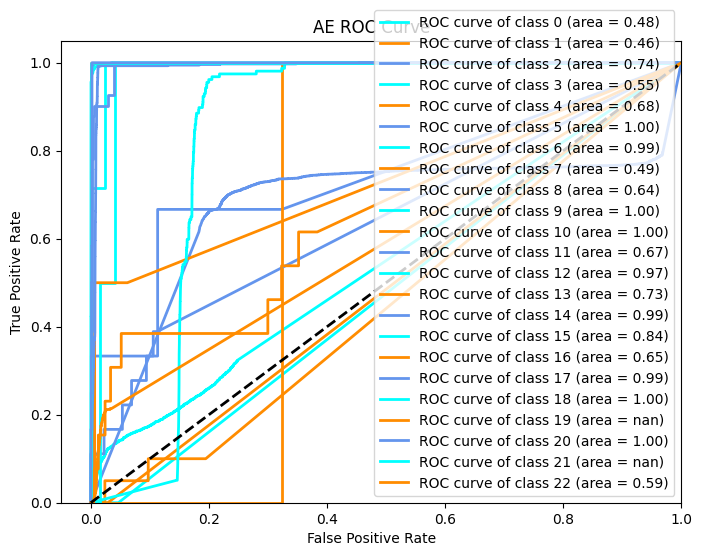

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from itertools import cycle
import numpy as np

def plot_roc_curve(y_true, y_score, n_classes, title='ROC Curve'):
    # Binarize the output
    y_test_binarized = label_binarize(y_true, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


y_score_mlp = mlp_mc.predict(X_test_mc)
plot_roc_curve(y_test_mc, y_score_mlp, n_classes=len(le_mc.classes_), title='MLP ROC Curve')

# y_score_lstm = lstm_mc.predict(X_test_mc)
# plot_roc_curve(y_test_mc, y_score, n_classes=len(le_mc.classes_), title='LSTM ROC Curve')

y_score_lstm = lstm_mc.predict(X_test_mc.astype(np.float32).values.reshape(-1, 1, X_test_mc.shape[1]))
# Reshape X_test_mc to 3D for LSTM, and convert to float32
plot_roc_curve(y_test_mc, y_score_lstm, n_classes=len(le_mc.classes_), title='LSTM ROC Curve')


y_score_ae = ae_mc.predict(ae_enc.predict(X_test_mc))
plot_roc_curve(y_test_mc, y_score_ae, n_classes=len(le_mc.classes_), title='AE ROC Curve')

**Model Comparison based on F1-score**

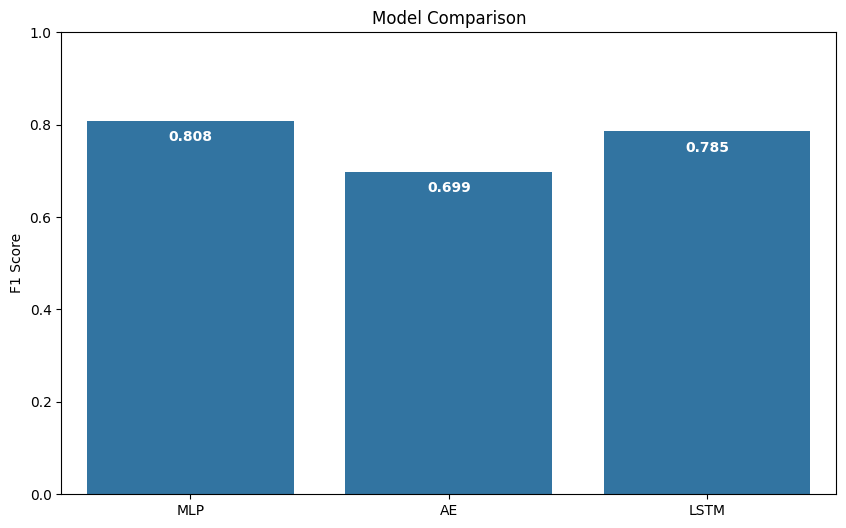

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_comparison(model_scores, title='Model Comparison'):
    models = list(model_scores.keys())
    scores = list(model_scores.values())

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=models, y=scores)
    plt.title(title)
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)

    # Add labels to the bars
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height - 0.05,
                f'{height:.3f}', ha='center', va='bottom', color='white', fontweight='bold')

    plt.show()


model_scores = {
    'MLP': f1_score(y_test_mc, mlp_mc_preds, average='weighted'),
    'AE': f1_score(y_test_mc, ae_mc_preds, average='weighted'),
    'LSTM': f1_score(y_test_mc, lstm_mc_preds, average='weighted')
}

plot_model_comparison(model_scores)


**Model Comparison based on Accuracy**

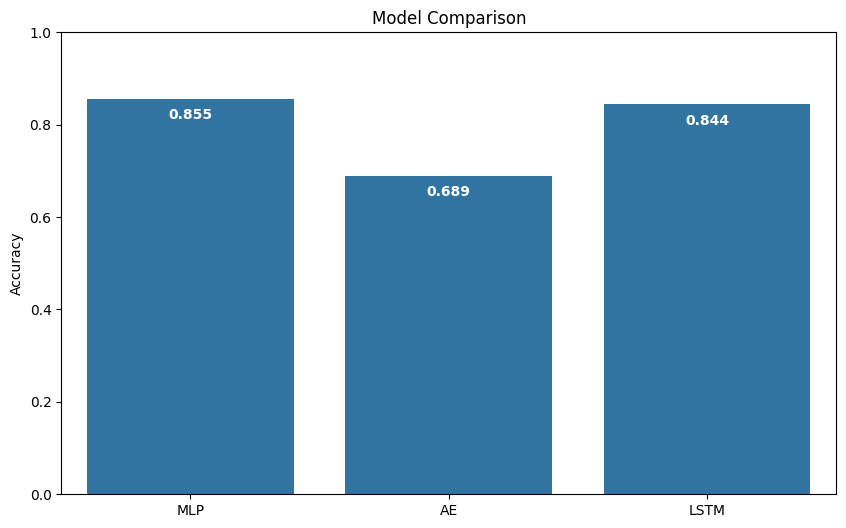

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

def plot_model_comparison(model_scores, title='Model Comparison'):
    models = list(model_scores.keys())
    scores = list(model_scores.values())

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=models, y=scores)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Add labels to the bars
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height - 0.05,
                f'{height:.3f}', ha='center', va='bottom', color='white', fontweight='bold')

    plt.show()


model_scores = {
    'MLP': accuracy_score(y_test_mc, mlp_mc_preds),
    'AE': accuracy_score(y_test_mc, ae_mc_preds),
    'LSTM': accuracy_score(y_test_mc, lstm_mc_preds)
}

plot_model_comparison(model_scores)

**FIN !!!**